In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

file_path = './data/EP9_RCVs_2022_06_22.xlsx'
file_path2 = './data/EP9_Voted_docs.xlsx'

df = pd.read_excel(file_path) 
df2 = pd.read_excel(file_path2) 







/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [8]:
print("=================DF================")
print("\nShape (Rows, Columns):")
print(df.shape)

print("\nColumn Names:")
print(df.columns)

print("\nFirst 5 Rows:")
print(df.head())

print("\nLast 5 Rows:")
print(df.tail())

print("=================DF2================")
print("\nShape(Rows, Columns):")
print(df2.shape)

print("\nColumn Names:")
print(df2.columns)

print("\nFirst 5 Rows:")
print(df2.head())

print("\nLast 5 Rows:")
print(df2.tail())

=================DF================

Shape (Rows, Columns):
(811, 13469)

Column Names:
Index(['WebisteEpID',       'Fname',       'Lname',    'FullName',
             'Activ',     'Country',       'Party',         'EPG',
             'Start',         'End',
       ...
               13450,         13451,         13452,         13453,
               13454,         13455,         13456,         13457,
               13458,         13459],
      dtype='object', length=13469)

First 5 Rows:
   WebisteEpID      Fname         Lname              FullName Activ   Country  \
0       197490  Magdalena     ADAMOWICZ  ADAMOWICZ, Magdalena   yes    Poland   
1       189525       Asim        ADEMOV          ADEMOV, Asim   yes  Bulgaria   
2       124831   Isabella      ADINOLFI    ADINOLFI, Isabella   yes     Italy   
3       197826     Matteo      ADINOLFI      ADINOLFI, Matteo   yes     Italy   
4       197403       Alex  AGIUS SALIBA    AGIUS SALIBA, Alex   yes     Malta   

                    

In [52]:

print("\nColumn Names:")
print(df.columns[11])

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

votes = df.iloc[:, 10:]

votes_array = votes.to_numpy()

similarity_matrix = cosine_similarity(votes_array)

covariance_matrix = pd.DataFrame(similarity_matrix, index=df['FullName'], columns=df['FullName'])





Column Names:
2


In [66]:
#Convert from similiarity to distance
distance_matrix = 1 - covariance_matrix 

#To avoid floating point errors we set values very close to 0 to 0
distance_matrix[distance_matrix < 1e-14] = 0
print(distance_matrix)

#subtract from each entry of D the mean of the corresponding row and the mean of the corresponding column, and add back the mean of all entries
n = distance_matrix.shape[0]

# Step 3: Double centering
# Subtract the mean of each row
row_means = distance_matrix.mean(axis=1)
distance_matrix_centered = distance_matrix.sub(row_means, axis=0)

# Subtract the mean of each column
col_means = distance_matrix.mean(axis=0)
distance_matrix_centered = distance_matrix_centered.sub(col_means, axis=1)

# Add back the mean of all entries
overall_mean = distance_matrix.mean().mean()
centered_matrix = distance_matrix_centered.add(overall_mean)
print(centered_matrix)




eigenvalues, eigenvectors = np.linalg.eigh(centered_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
top_two_eigenvectors = eigenvectors[:, sorted_indices[:2]]

coordinates = np.sqrt(np.abs(eigenvalues[sorted_indices[:2]])) * top_two_eigenvectors
mep_coordinates = coordinates[:, :2]
mep_positions = pd.DataFrame(mep_coordinates, index=covariance_matrix.index, columns=['X', 'Y'])
#print(mep_positions)





FullName              ADAMOWICZ, Magdalena  ADEMOV, Asim  ADINOLFI, Isabella  \
FullName                                                                       
ADAMOWICZ, Magdalena              0.000000      0.078935            0.151074   
ADEMOV, Asim                      0.078935      0.000000            0.134180   
ADINOLFI, Isabella                0.151074      0.134180            0.000000   
ADINOLFI, Matteo                  0.201780      0.166667            0.167068   
AGIUS SALIBA, Alex                0.199209      0.177869            0.149450   
...                                    ...           ...                 ...   
LUCKE, Karsten                    0.653688      0.652848            0.684357   
RINZEMA, Catharina                0.614095      0.605478            0.657886   
LAURETI, Camilla                  0.601942      0.592452            0.648391   
REPASI, René                      0.656297      0.652842            0.679535   
NEMEC, Matjaž                     0.8658

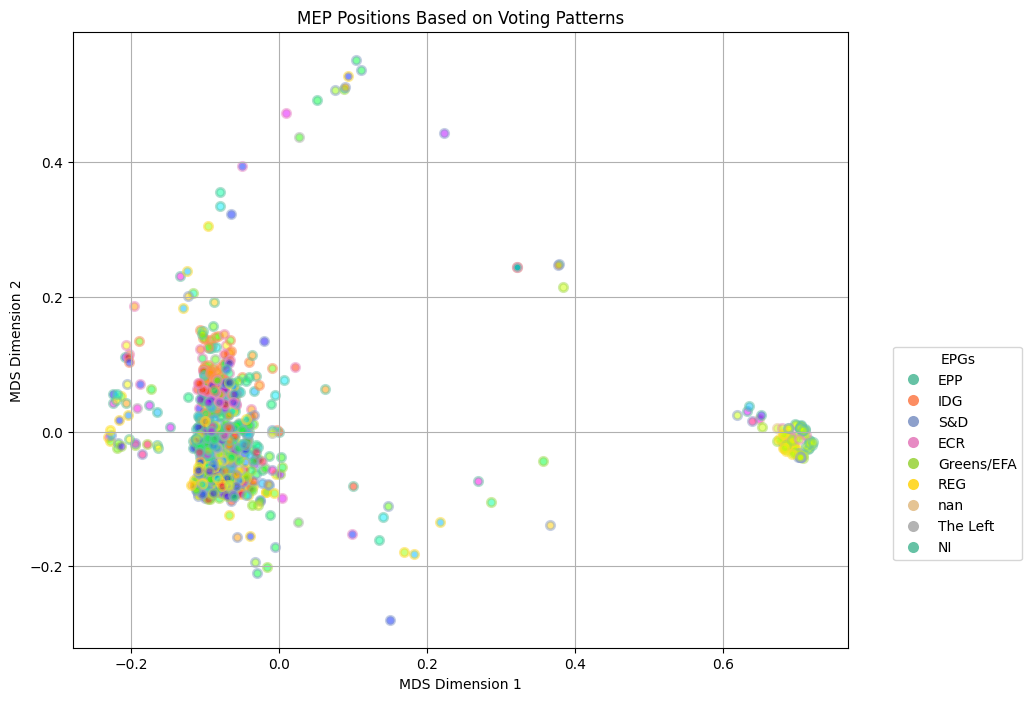

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'mep_positions' is the DataFrame with MEP (x, y) coordinates
# and 'df' is your original DataFrame with MEP information

# Merge the coordinate data with country and EPG information
plot_data = mep_positions.merge(df[['FullName', 'Country', 'EPG']], left_index=True, right_on='FullName')

# Assign colors to each country and EPG
country_colors = sns.color_palette('hsv', len(plot_data['Country'].unique()))
epg_colors = sns.color_palette('Set2', len(plot_data['EPG'].unique()))
country_to_color = dict(zip(plot_data['Country'].unique(), country_colors))
epg_to_color = dict(zip(plot_data['EPG'].unique(), epg_colors))

# Create the plot
plt.figure(figsize=(10, 8))
for _, row in plot_data.iterrows():
    # Use color to represent both country and EPG
    plt.scatter(row['X'], row['Y'], color=country_to_color[row['Country']], alpha=0.5, 
                edgecolors=epg_to_color[row['EPG']], linewidth=2)

# Add legends for Country and EPG
country_patches = [plt.Line2D([0], [0], marker='o', color='w', label=country, 
                              markersize=10, markerfacecolor=color) for country, color in country_to_color.items()]
epg_patches = [plt.Line2D([0], [0], marker='o', color='w', label=epg, 
                          markersize=10, markerfacecolor=color, markeredgewidth=2) for epg, color in epg_to_color.items()]

plt.legend(handles=country_patches, title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(handles=epg_patches, title='EPGs', bbox_to_anchor=(1.05, 0.5), loc='upper left')

plt.title('MEP Positions Based on Voting Patterns')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()



